## generate 2D synthetic Data For Outlier Detection

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs, make_moons

import numpy as np

use the code in the next cell to explore how novelty detection (OneClassSVM) and outlier detection methods (LOF, Isolation Forest) perform when you vary:
 - outliers_fraction:  0.01, 0.05, 0.1
 - num_clusters: 5,10
 

### settings

In [4]:
n_samples = 2000

# modify these settings to obtain different combinations of high density areas (clusters) and outliers
outliers_fraction = 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
num_clusters = 10
stdev = 1
n_features = 2

print("total samples: {s} outliers: {o}%, outliers expected:{ot}, inliers:{i}".format(s=n_samples, o=outliers_fraction, ot=n_outliers, i=n_inliers))
print("blobs: centers: {c}, samples = {n}, std dev: {std}".format(c=num_clusters, n=n_inliers, std=stdev))

total samples: 2000 outliers: 0.1%, outliers expected:200, inliers:1800
blobs: centers: 10, samples = 1800, std dev: 1


### creating the synthetic dataset

In [94]:
samples, cluster_labels, centers = make_blobs(centers=num_clusters, cluster_std=stdev, random_state=0, n_samples=n_inliers, n_features=n_features, return_centers=True)

print("clustered samples: {s}".format(s=len(samples)))

## range of samples points -- used to determine the boundaries for outliers generation
boost = 1.1   ## extends the range covered by the clusters
xmin = min(samples[:,0]) 
xmax = max(samples[:,0]) 
ymin = min(samples[:,1]) 
ymax = max(samples[:,1]) 
print("xmin: {xmin:.2f}, xmax: {xmax:.2f}".format(xmin=xmin, xmax=xmax))
print("ymin: {ymin:.2f}, ymax: {ymax:.2f}".format(ymin=ymin, ymax=ymax))

low = min(xmin, ymin) * boost
high = max(xmax, ymax) * boost
print("low, high for outliers: {low:.2f}, {high:.2f}".format(low=low, high=high))

# Add n_outlier outliers, n_features each 
rng = np.random.RandomState(42)
outliers = rng.uniform(low=low, high=high, size=(n_outliers, n_features))
print("number of outliers produced: {o}".format(o=len(outliers)))

## some of the outliers are within clusters. 
## we use the distance from centers to remove some of the outliers, and those will never be detected
distances = dict()
out = dict()
i=0
for o in outliers:
    mindist = 1000000
    for c in centers:
        dist = np.linalg.norm(o-c)  ## euclidean distance
        if dist < mindist:
            mindist = dist
    out[i] = o
    distances[i]= mindist
    i = i + 1

distarray = np.asarray(list(distances.values()))
meandist  = np.mean(distarray)
vardist   = np.std(distarray)

print("outliers distances from centres: mean {m:.2f}, var {v:.2f}".format(m=meandist, v=vardist))

## remove points that are too close to the centers

alphsa
removed = 0
for i in range(len(outliers)):
    if distances[i] < meandist-vardist * alpha:
        print("removing {d:.2f}".format(d=distances[i]))
        out.pop(i)
        removed = removed + 1

finalOutliers = np.asarray(list(out.values()))
print("removed {r} outliers. {n} remaining outliers ".format(r=removed, n=len(finalOutliers)))

clustered samples: 900
xmin: -11.75, xmax: 11.87
ymin: -10.79, ymax: 10.76
low, high for outliers: -12.93, 13.05
number of outliers produced: 100
outliers distances from centres: mean 4.52, var 2.32
removing 2.06
removing 0.69
removing 2.07
removing 0.39
removing 0.40
removing 2.09
removing 1.49
removing 1.30
removing 1.39
removing 1.88
removing 1.07
removing 1.47
removing 1.44
removing 1.52
removing 1.12
removing 1.15
removing 1.16
removing 1.94
removing 1.48
removed 19 outliers. 81 remaining outliers 


### visualising the challenge dataset

Text(0.5, 1.0, 'clusters with outliers after removing points close to cluster centers')

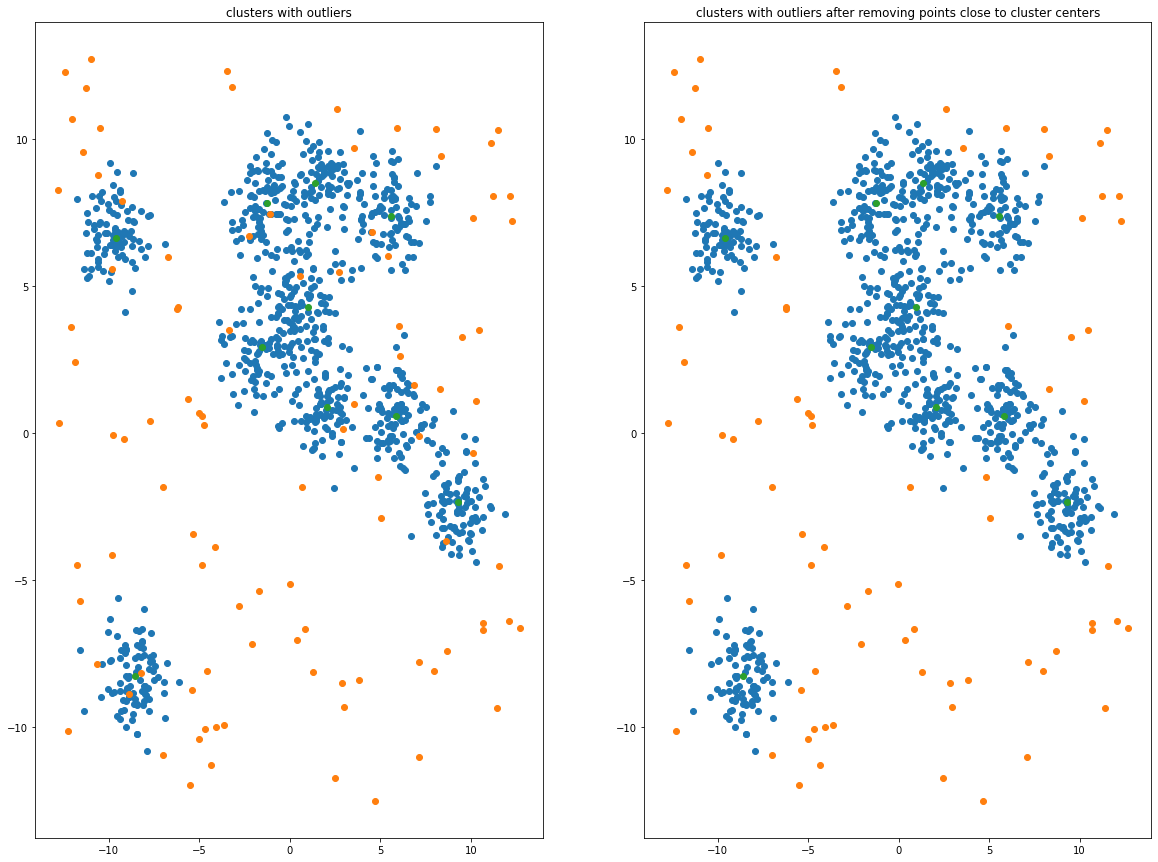

In [95]:
fig, ax = plt.subplots(1,2, figsize=(20,15))

ax[0].scatter(samples[:,0], samples[:,1])
ax[0].scatter(outliers[:,0], outliers[:,1])
ax[0].scatter(centers[:,0], centers[:,1])
ax[0].set_title("clusters with outliers")

    
ax[1].scatter(samples[:,0], samples[:,1])
ax[1].scatter(finalOutliers[:,0], finalOutliers[:,1])
ax[1].scatter(centers[:,0], centers[:,1])
ax[1].set_title("clusters with outliers after removing points close to cluster centers")

In [88]:
## this is the set you will use for anomaly detection
full_set = np.concatenate([samples, finalOutliers], axis=0)

### note: use `finalOutlier` as your set of "ground truth" outliers